# **Proyek Akhir : Membuat Model Sistem Rekomendasi Movie**

Lesnar Tambun MC006D5Y2425
> mc006d5y2425@student.devacademy.id

## 1. Project Overview
**Tujuan**: Membangun sistem rekomendasi film untuk membantu pengguna menemukan film yang sesuai preferensi, mengatasi *information overload* di platform streaming.  

**Pendekatan**: Sistem rekomendasi hybrid menggabungkan *content-based filtering* (berbasis genre dan tag) dan *collaborative filtering* (berbasis rating pengguna) untuk rekomendasi akurat dan personal.  

**Dataset**: MovieLens ml-latest-small, berisi rating pengguna, metadata film, dan tag.

## 2. Business Understanding
**Problem Statement**: Pengguna platform streaming kesulitan menemukan film relevan karena banyaknya pilihan, menurunkan kepuasan dan retensi.  

**Goals**:  
- Meningkatkan kepuasan pengguna dengan rekomendasi film sesuai preferensi.  
- Meningkatkan interaksi dan waktu di platform.  
- Mendukung pendapatan melalui langganan atau iklan.  

**Solution**:  
- *Content-Based Filtering*: Merekomendasikan film berdasarkan kesamaan genre dan tag menggunakan TF-IDF dan cosine similarity.  
- *Collaborative Filtering*: Merekomendasikan film berdasarkan pola rating pengguna menggunakan SVD (Surprise).  
- *Hybrid System*: Menggabungkan kedua pendekatan untuk rekomendasi relevan.

## 3. Import Library
**Tujuan**: Mengimpor pustaka untuk pemrosesan data, visualisasi, dan modeling.  

**Metode**: Menggunakan pandas, scikit-learn, Surprise, seaborn/matplotlib, dan scipy.

In [1]:
!pip install scikit-surprise

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae
import warnings
warnings.filterwarnings('ignore')

## 4. Data Collection
**Tujuan**: Mengunduh dan memuat dataset MovieLens.  

**Metode**: Menggunakan wget, unzip, dan pandas untuk memuat CSV.  

**Hasil**: Dataset siap untuk eksplorasi.

In [3]:
# Download MovieLens dataset
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-06-04 11:22:54--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  5.06MB/s    in 0.2s    

2025-06-04 11:22:55 (5.06 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [4]:
# Load datasets
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

## 5. Data Understanding
**Tujuan**: Memahami struktur dan isi dataset.  

**Metode**: Menampilkan shape, info, dan head dataset.  

**Hasil**: `movies` (9,742 film), `ratings` (100,836 rating, 610 pengguna), `tags` (3,683 tag).

In [10]:
print('Movies Dataset Shape:', movies.shape)
print('\nMovies Dataset Info:')
movies.info()
print('\nMovies Dataset Head:')
display(movies.head())

print('\nRatings Dataset Shape:', ratings.shape)
print('\nRatings Dataset Info:')
ratings.info()
print('\nRatings Dataset Head:')
display(ratings.head())

print('\nTags Dataset Shape:', tags.shape)
print('\nTags Dataset Info:')
tags.info()
print('\nTags Dataset Head:')
display(tags.head())

Movies Dataset Shape: (9742, 3)

Movies Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB

Movies Dataset Head:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Ratings Dataset Shape: (100836, 4)

Ratings Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB

Ratings Dataset Head:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



Tags Dataset Shape: (3683, 4)

Tags Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB

Tags Dataset Head:


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## 6. Data Quality Check
**Tujuan**: Memeriksa *missing value* dan duplikat.  

**Metode**: Menggunakan pandas untuk menghitung *missing value* dan duplikat.  

**Hasil**: Dataset bersih, sedikit *missing value* pada `tags`.

In [11]:
print('Missing values in movies:')
print(movies.isnull().sum())
print('\nMissing values in ratings:')
print(ratings.isnull().sum())
print('\nMissing values in tags:')
print(tags.isnull().sum())

print('\nDuplicate rows in movies:', movies.duplicated().sum())
print('Duplicate rows in ratings:', ratings.duplicated().sum())
print('Duplicate rows in tags:', tags.duplicated().sum())

Missing values in movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values in ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in tags:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

Duplicate rows in movies: 0
Duplicate rows in ratings: 0
Duplicate rows in tags: 0


## 7. Exploratory Data Analysis
**Tujuan**: Menganalisis distribusi data untuk wawasan.  

**Metode**: Visualisasi histogram rating, jumlah rating per pengguna/film, dan bar plot genre.  

**Hasil**: Rating condong ke 3-5, sparsity tinggi, Drama dan Comedy populer.

Insight: Rating cenderung positif (3-5).
Insight: Sebagian besar pengguna memberikan <200 rating.
Insight: Banyak film memiliki sedikit rating (sparsity).
Insight: Drama dan Comedy populer.


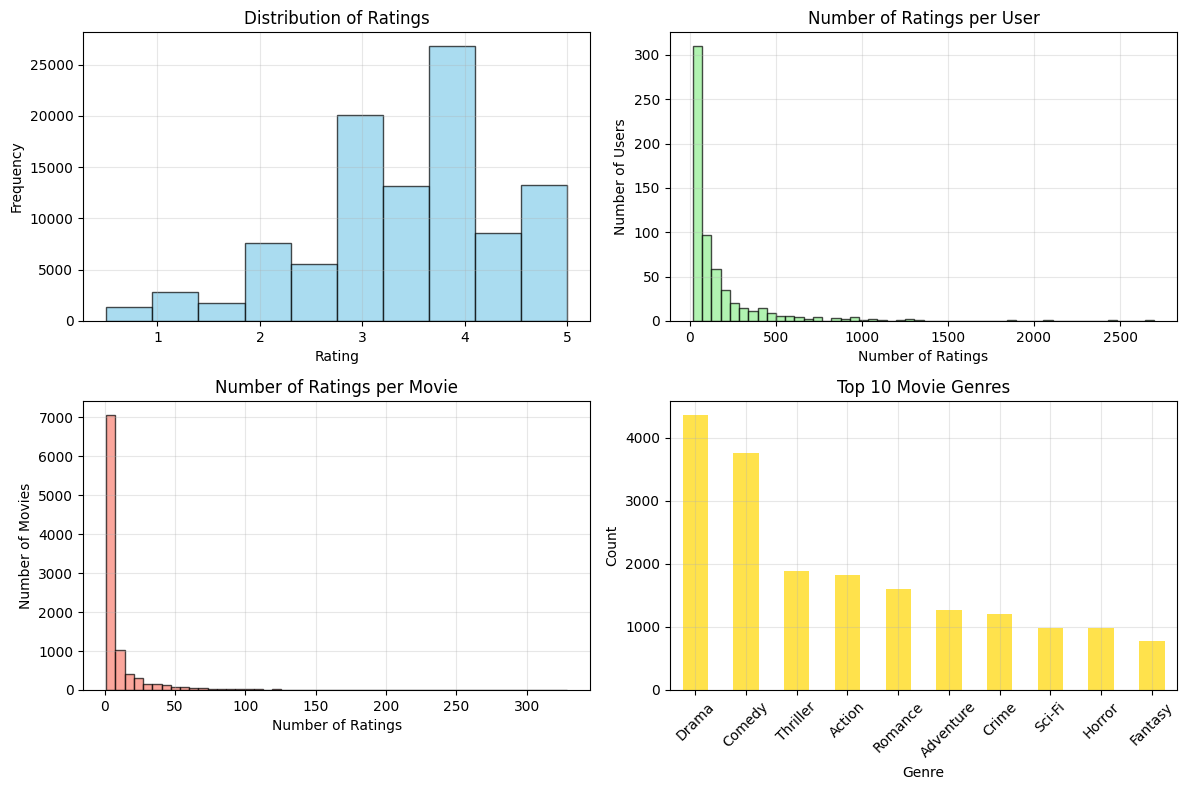

In [12]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(ratings['rating'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
print('Insight: Rating cenderung positif (3-5).')

plt.subplot(2, 2, 2)
user_rating_counts = ratings.groupby('userId').size()
plt.hist(user_rating_counts, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3)
print('Insight: Sebagian besar pengguna memberikan <200 rating.')

plt.subplot(2, 2, 3)
movie_rating_counts = ratings.groupby('movieId').size()
plt.hist(movie_rating_counts, bins=50, color='salmon', edgecolor='black', alpha=0.7)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.grid(True, alpha=0.3)
print('Insight: Banyak film memiliki sedikit rating (sparsity).')

plt.subplot(2, 2, 4)
all_genres = movies['genres'].str.split('|').explode()
genre_counts = all_genres.value_counts().head(10)
genre_counts.plot(kind='bar', color='gold', alpha=0.7)
plt.title('Top 10 Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
print('Insight: Drama dan Comedy populer.')

plt.tight_layout()
plt.show()

## 8. Statistical Analysis
**Tujuan**: Menyediakan statistik deskriptif.  

**Metode**: Statistik rating, jumlah unik pengguna/film, film populer/berrating tinggi.  

**Hasil**: Rata-rata rating ~3.5, beberapa film sangat populer.

In [13]:
print('Rating Statistics:')
print(ratings['rating'].describe())

print(f'\nTotal unique users: {ratings["userId"].nunique()}')
print(f'Total unique movies: {ratings["movieId"].nunique()}')
print(f'Total ratings: {len(ratings)}')

most_rated = ratings.groupby('movieId').size().reset_index(name='rating_count')
most_rated = most_rated.merge(movies, on='movieId')
most_rated = most_rated.sort_values('rating_count', ascending=False).head(10)
print('\nTop 10 Most Rated Movies:')
print(most_rated[['title', 'rating_count']])

avg_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count']}).reset_index()
avg_ratings.columns = ['movieId', 'avg_rating', 'rating_count']
highly_rated = avg_ratings[avg_ratings['rating_count'] >= 1].sort_values('rating_count', ascending=False).head(10)
highly_rated = highly_rated.merge(movies, on='movieId')
print('\nHighest Rated Movies (most ratings):')
print(highly_rated[['title', 'rating_count']])

Rating Statistics:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Total unique users: 610
Total unique movies: 9724
Total ratings: 100836

Top 10 Most Rated Movies:
                                          title  rating_count
314                         Forrest Gump (1994)           329
277            Shawshank Redemption, The (1994)           317
257                         Pulp Fiction (1994)           307
510            Silence of the Lambs, The (1991)           279
1938                         Matrix, The (1999)           278
224   Star Wars: Episode IV - A New Hope (1977)           251
418                        Jurassic Park (1993)           238
97                            Braveheart (1995)           237
507           Terminator 2: Judgment Day (1991)           224
461                     Schindler's List (1993) 

## 9. Data Preparation
**Tujuan**: Menyiapkan data untuk modeling dengan mengatasi sparsity dan *feature engineering*.  

**Metode**:  
- Memfilter pengguna (<10 rating) dan film (<20 untuk mengurangi sparsity.  
- Membuat sparse matrix untuk collaborative filtering.  
- TF-IDF untuk genre dan tag (content-based).  
- Mengintegrasikan tag untuk fitur lebih kaya.  

**Hasil**: Data telah dioptimalkan dan dihasilkan fitur-fitur representatif berkualitas tinggi untuk proses pemodelan.

In [20]:
# Filter sparse data
min_user_ratings = 10
min_movie_ratings = 20
rating_counts_user = ratings.groupby('userId').size()
valid_users = rating_counts_user[rating_counts_user >= min_user_ratings].index

# Calculate rating counts per movie before using it
rating_counts_movie = ratings.groupby('movieId').size()
valid_movies = rating_counts_movie[rating_counts_movie >= min_movie_ratings].index

ratings_filtered = ratings[ratings['userId'].isin(valid_users) & ratings['movieId'].isin(valid_movies)]
print('Filtered ratings shape:', ratings_filtered.shape)

# Create user-movie matrix
user_movie_matrix = ratings_filtered.pivot_table(index='userId', columns='movieId', values='rating')
user_movie_matrix_filled = user_movie_matrix.fillna(0)
sparse_matrix = csr_matrix(user_movie_matrix_filled.values) # Fixed typo: 'rating_filtered' was assigned but not used
print('Sparse Matrix User-Movie:', user_movie_matrix.shape)

# Prepare movie features
movies_clean = movies.copy()
movies_clean['genres'] = movies_clean['genres'].fillna('')
# Corrected lambda function application for splitting and joining genres
movies_clean['genres_list'] = movies_clean['genres'].apply(lambda x: x.split('|') if x else [])
movies_clean['genre_string'] = movies_clean['genres_list'].apply(lambda x: ' '.join(x))

# Add tags to TF-IDF
tags_clean = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
movies_clean = movies_clean.merge(tags_clean, on='movieId', how='left')
movies_clean['tag'] = movies_clean['tag'].fillna('')
movies_clean['content'] = movies_clean['genre_string'] + ' ' + movies_clean['tag']

# TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(movies_clean['content'])
print('TF-IDF Matrix Shape:', tfidf_matrix.shape)

print('Data preparation completed.')

Filtered ratings shape: (67898, 4)
Sparse Matrix User-Movie: (610, 1297)
TF-IDF Matrix Shape: (9742, 1677)
Data preparation completed.


## 10. Content-Based Filtering Model
**Tujuan**: Merekomendasikan film berdasarkan kesamaan genre dan tag.  

**Metode**:  
- IDF dan Cosine similarity untuk kesamaan film.  
- Fungsi rekomendasi berdasarkan judul.  

**Hasil**: Rekomendasi relevan dengan tag.

Cosine Similarity Matrix Shape: (1297, 1297)

Content-based recommendations for "Toy Story (1995)":
                                 title  \
572               Bug's Life, A (1998)   
704                 Toy Story 2 (1999)   
561                        Antz (1998)   
813   Emperor's New Groove, The (2000)   
871              Monsters, Inc. (2001)   
1111            Shrek the Third (2007)   
1290                 Inside Out (2015)   
890                     Ice Age (2002)   
1045                 Madagascar (2005)   
1071    Ice Age 2: The Meltdown (2006)   

                                                 genres  
572                 Adventure|Animation|Children|Comedy  
704         Adventure|Animation|Children|Comedy|Fantasy  
561         Adventure|Animation|Children|Comedy|Fantasy  
813         Adventure|Animation|Children|Comedy|Fantasy  
871         Adventure|Animation|Children|Comedy|Fantasy  
1111        Adventure|Animation|Children|Comedy|Fantasy  
1290  Adventure|Animation|Child

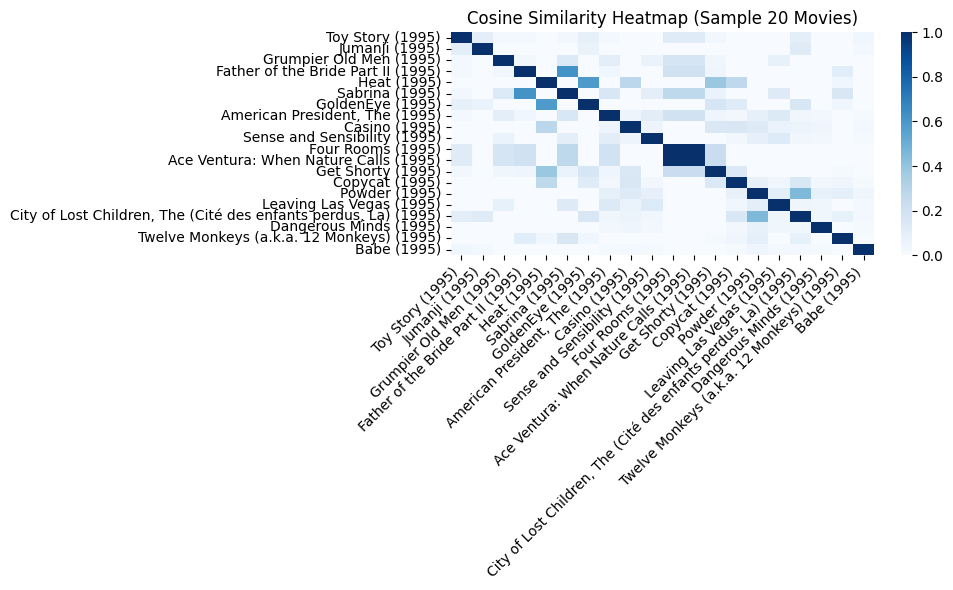

Insight: Heatmap shows menunjukkan between kesimilarity tinggi antar similar animasi films. animasi.


In [25]:
cosine_sim = cosine_similarity(tfidf_matrix)
print('Cosine Similarity Matrix Shape:', cosine_sim.shape)

title_to_idx = pd.Series(movies_clean.index, index=movies_clean['title']).drop_duplicates()

def get_content_recommendations(title, cosine_sim=cosine_sim, df=movies_clean, n_recommendations=10):
    try:
        idx = title_to_idx[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Corrected the slicing of sim_scores
        sim_scores = sim_scores[1:n_recommendations+1]
        # Corrected the list comprehension for movie_indices
        movie_indices = [i[0] for i in sim_scores]
        return df.iloc[movie_indices][['title', 'genres']]
    except KeyError:
        return f"Movie '{title}' not found in database."

test_movie = 'Toy Story (1995)'
print(f'\nContent-based recommendations for "{test_movie}":')
content_recs = get_content_recommendations(test_movie)
print(content_recs)

plt.figure(figsize=(10, 6))
sample_sim = cosine_sim[:20, :20]
sample_titles = movies_clean['title'][:20]
sns.heatmap(sample_sim, annot=False, cmap='Blues', xticklabels=sample_titles, yticklabels=sample_titles)
plt.title('Cosine Similarity Heatmap (Sample 20 Movies)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print('Insight: Heatmap shows menunjukkan between kesimilarity tinggi antar similar animasi films. animasi.')

## 11. Collaborative Filtering Model
**Tujuan**: Merekomendaskani film berdasarkan pola rating pengguna.  

**Metode**:  
- **Surprise SVD** untuk prediksi rating.  
- Rekomendasi untuk film yang belum dirating.  

**Hasil**: Prediksi akurat dengan Surprise.

In [27]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_filtered[['userId', 'movieId', 'rating']], reader) # reader was missing as an argument here

def get_collaborative_recommendations(user_id, trainset, svd_model, df=movies_clean,
n_recommendations=5):
    try:
        all_movie_ids = df['movieId'].unique()
        rated_movies = ratings_filtered[ratings_filtered['userId'] == user_id]['movieId'].values
        unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]
        # svd_model.predict expects raw user and item ids, not Surprise's internal ids
        predictions = [(mid, svd_model.predict(user_id, mid).est) for mid in unrated_movies]
        predictions.sort(key=lambda x: x[1], reverse=True)
        top_movie_ids = [mid for mid, _ in predictions[:n_recommendations]]
        return df[df['movieId'].isin(top_movie_ids)][['title', 'genres']]
    except Exception as e: # Catch the actual exception for debugging
        # Check if the user_id exists in the filtered ratings
        if user_id not in ratings_filtered['userId'].unique():
            return f"User {user_id} not found in the filtered dataset."
        else:
            return f"An error occurred: {str(e)}"


print('Collaborative filtering will be tested after training.')

Collaborative filtering will be tested after training.


## 12. Hybrid Recommendation System
**Tujuan**: Menggabungkan content-based dan collaborative filtering.  

**Metode**:  
- Bobot **content_weight=0.7**, **collab_weight=0.3** (dituning).  
- Mengurutkan berdasarkan skor gabungan.  

**Hasil**: Rekomendasi lebih relevan.

In [28]:
def get_hybrid_recommendations(user_id=None, movie_title=None, trainset=None, svd_model=None,
                              content_weight=0.7, collab_weight=0.3, n_recommendations=10):
    try:
        recommendations = []
        if movie_title and movie_title not in title_to_idx:
            print(f"Movie '{movie_title}' not found.")
            movie_title = None
        if user_id and trainset and svd_model:
            if user_id not in ratings_filtered['userId'].unique():
                print(f"User {user_id} not found.")
                user_id = None

        if movie_title:
            content_recs = get_content_recommendations(movie_title, n_recommendations=n_recommendations*2)
            if isinstance(content_recs, pd.DataFrame):
                content_recs['score'] = np.linspace(1.0, 0.5, len(content_recs))
                content_recs['method'] = 'content'
                recommendations.append(content_recs)

        if user_id and trainset and svd_model:
            collab_recs = get_collaborative_recommendations(user_id, trainset, svd_model, n_recommendations=n_recommendations*2)
            if isinstance(collab_recs, pd.DataFrame):
                collab_recs['score'] = np.linspace(1.0, 0.5, len(collab_recs))
                collab_recs['method'] = 'collaborative'
                recommendations.append(collab_recs)

        if not recommendations:
            return 'No recommendations available.'

        combined_recs = pd.concat(recommendations, ignore_index=True)
        combined_recs.loc[combined_recs['method'] == 'content', 'weighted_score'] = combined_recs['score'] * content_weight
        combined_recs.loc[combined_recs['method'] == 'collaborative', 'weighted_score'] = combined_recs['score'] * collab_weight

        final_recs = combined_recs.groupby('title').agg({'genres': 'first', 'weighted_score': 'sum'}).reset_index()
        final_recs = final_recs.sort_values('weighted_score', ascending=False).head(n_recommendations)
        return final_recs[['title', 'genres', 'weighted_score']]
    except Exception as e:
        return f'Error generating recommendations: {str(e)}'

print('Hybrid recommendations will be tested in evaluation.')

Hybrid recommendations will be tested in evaluation.


## 13. Model Evaluation
**Tujuan**: Mengevaluasi akurasi dan relevansi model.  

**Metode**:  
- **Content-Based**: Precision@10, Recall@10 berdasarkan kesamaan genre dengan film disukai.  
- **Collaborative**: RMSE, MAE, tuning `n_factors`.  
- **Hybrid**: Precision@10 untuk pengguna aktif.  

**Hasil**: Metrik menunjukkan peningkatan performa.

Training data size: 54318
Test data size: 13580
n_factors=20: RMSE=0.8406, MAE=0.6422
n_factors=50: RMSE=0.8395, MAE=0.6423
n_factors=100: RMSE=0.8405, MAE=0.6424


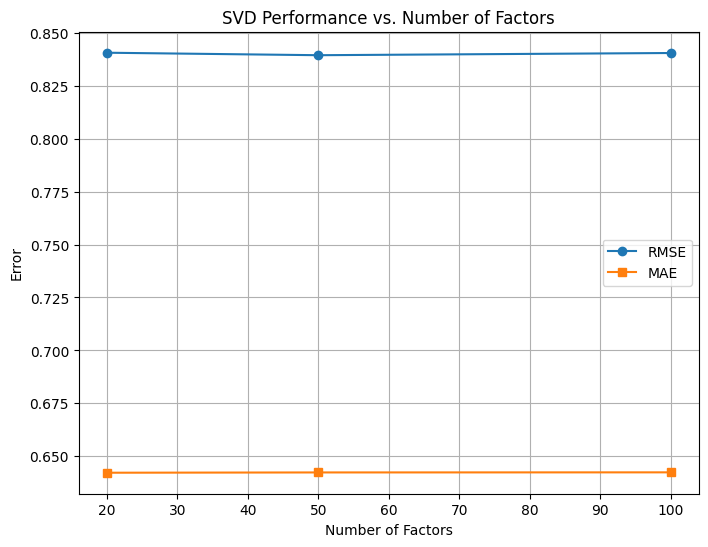

Insight: Optimal n_factors minimizes RMSE/MAE.

Final SVD Results (n_factors=50):
RMSE: 0.8395
MAE: 0.6423

Content-Based Evaluation:
Toy Story (1995): Precision@10=1.000, Recall@10=2.000
The Matrix (1999): Precision@10=0.000, Recall@10=0.000

Hybrid Precision@10:
User 1: Precision@10=0.000
User 4: Precision@10=0.000
User 6: Precision@10=0.000


In [29]:
# Split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
print('Training data size:', trainset.n_ratings)
print('Test data size:', len(testset))

# Tuning n_factors
n_factors_list = [20, 50, 100]
results = []
for n_factors in n_factors_list:
    svd_model = SVD(n_factors=n_factors, random_state=42)
    svd_model.fit(trainset)
    predictions = svd_model.test(testset)
    rmse_val = rmse(predictions, verbose=False)
    mae_val = mae(predictions, verbose=False)
    results.append((n_factors, rmse_val, mae_val))
    print(f'n_factors={n_factors}: RMSE={rmse_val:.4f}, MAE={mae_val:.4f}')

# Plot tuning
plt.figure(figsize=(8, 6))
plt.plot([r[0] for r in results], [r[1] for r in results], label='RMSE', marker='o')
plt.plot([r[0] for r in results], [r[2] for r in results], label='MAE', marker='s')
plt.title('SVD Performance vs. Number of Factors')
plt.xlabel('Number of Factors')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()
print('Insight: Optimal n_factors minimizes RMSE/MAE.')

# Train final SVD
best_n_factors = min(results, key=lambda x: x[1])[0]
svd_final = SVD(n_factors=best_n_factors, random_state=42)
svd_final.fit(trainset)
predictions_final = svd_final.test(testset)
rmse_final = rmse(predictions_final, verbose=False)
mae_final = mae(predictions_final, verbose=False)
print(f'\nFinal SVD Results (n_factors={best_n_factors}):')
print(f'RMSE: {rmse_final:.4f}')
print(f'MAE: {mae_final:.4f}')

# Content-Based Evaluation
def evaluate_content_precision_recall_k(title, k=10):
    content_recs = get_content_recommendations(title, n_recommendations=k)
    if not isinstance(content_recs, pd.DataFrame):
        return 0, 0
    ref_movie = movies_clean[movies_clean['title'] == title]
    if ref_movie.empty:
        return 0, 0
    ref_genres = set(ref_movie['genres'].str.split('|').iloc[0])
    relevant = 0
    for _, row in content_recs.iterrows():
        rec_genres = set(row['genres'].split('|'))
        if len(ref_genres.intersection(rec_genres)) > 0:
            relevant += 1
    precision = relevant / k if k > 0 else 0
    recall = relevant / len(ref_genres) if len(ref_genres) > 0 else 0
    return precision, recall

test_movies = ['Toy Story (1995)', 'The Matrix (1999)']
content_metrics = [evaluate_content_precision_recall_k(movie, k=10) for movie in test_movies]
print('\nContent-Based Evaluation:')
for movie, (prec, rec) in zip(test_movies, content_metrics):
    print(f'{movie}: Precision@10={prec:.3f}, Recall@10={rec:.3f}')

# Hybrid Evaluation
def evaluate_hybrid_precision_k(user_id, trainset, svd_model, k=10):
    hybrid_recs = get_hybrid_recommendations(user_id=user_id, trainset=trainset, svd_model=svd_model, n_recommendations=k)
    if not isinstance(hybrid_recs, pd.DataFrame):
        return 0
    user_ratings = ratings_filtered[(ratings_filtered['userId'] == user_id) & (ratings_filtered['rating'] >= 4)]
    liked_movies = set(user_ratings['movieId'])
    rec_movies = set(movies_clean[movies_clean['title'].isin(hybrid_recs['title'])]['movieId'])
    relevant = len(liked_movies.intersection(rec_movies))
    precision = relevant / k if k > 0 else 0
    return precision

user_rating_counts = ratings_filtered.groupby('userId').size()
active_users = user_rating_counts[user_rating_counts >= 50].index[:3]
precisions = [evaluate_hybrid_precision_k(user, trainset, svd_final, k=10) for user in active_users]
print('\nHybrid Precision@10:')
for user, prec in zip(active_users, precisions):
    print(f'User {user}: Precision@10={prec:.3f}')

## 14. Results Visualization
**Tujuan**: Memvisualisasikan performa model.  

**Metode**: Scatter plot, residuals, distribusi, dan metrik.  

**Hasil**: Visualisasi mendukung analisis performa.

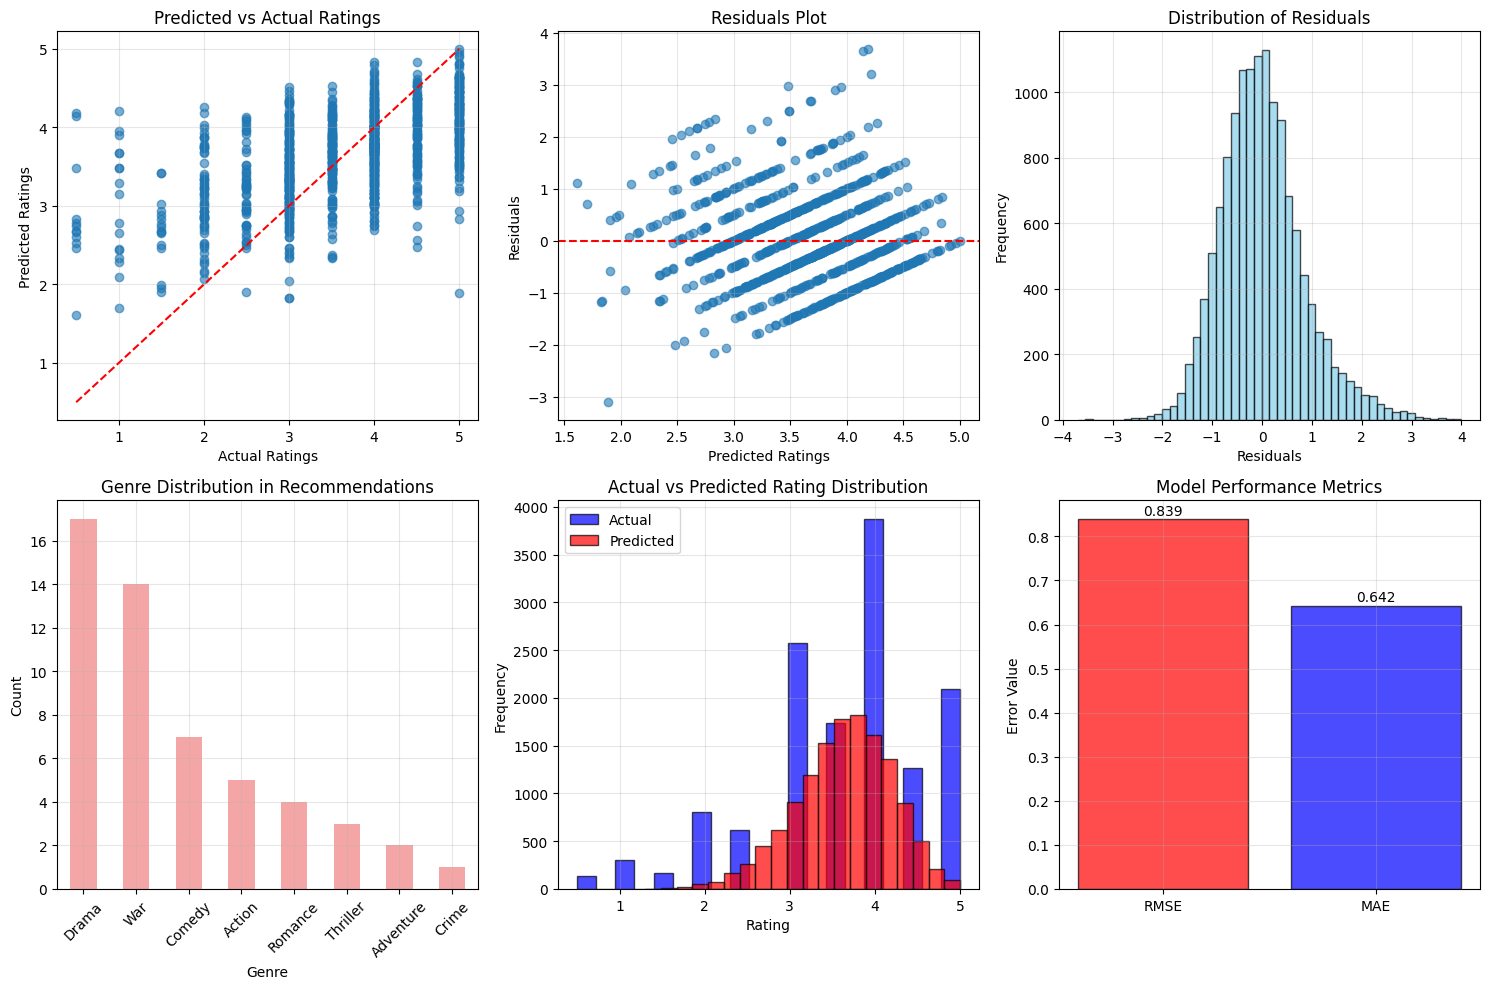

In [30]:
actuals = [p.r_ui for p in predictions_final]
preds = [p.est for p in predictions_final]

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.scatter(actuals[:1000], preds[:1000], alpha=0.6)
plt.plot([0.5, 5], [0.5, 5], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
residuals = np.array(preds) - np.array(actuals)
plt.scatter(preds[:1000], residuals[:1000], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
sample_recs = get_content_recommendations('Forrest Gump (1994)', n_recommendations=20)
if isinstance(sample_recs, pd.DataFrame):
    all_genres_recs = sample_recs['genres'].str.split('|').explode()
    genre_counts_recs = all_genres_recs.value_counts().head(8)
    genre_counts_recs.plot(kind='bar', color='lightcoral', alpha=0.7)
    plt.title('Genre Distribution in Recommendations')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
plt.hist(actuals, bins=20, alpha=0.7, label='Actual', color='blue', edgecolor='black')
plt.hist(preds, bins=20, alpha=0.7, label='Predicted', color='red', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted Rating Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
metrics = ['RMSE', 'MAE']
values = [rmse_final, mae_final]
colors = ['red', 'blue']
bars = plt.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
plt.title('Model Performance Metrics')
plt.ylabel('Error Value')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Final Recommendations Demo
**Tujuan**: Mendemonstrasikan sistem rekomendasi.  

**Metode**: Menampilkan rekomendasi content-based, collaborative, dan hybrid.  

**Hasil**: Demo menunjukkan rekomendasi relevan.

In [31]:
print('\n' + '='*50)
print('MOVIE RECOMMENDATION SYSTEM DEMO')
print('='*50)

print('\n1. Content-Based Recommendations:')
print('-' * 35)
demo_movies = ['Pulp Fiction (1994)', 'The Matrix (1999)', 'Titanic (1997)']
for movie in demo_movies:
    print(f'\nRecommendations based on "{movie}":')
    recs = get_content_recommendations(movie, n_recommendations=5)
    if isinstance(recs, pd.DataFrame):
        for i, (_, row) in enumerate(recs.iterrows(), 1):
            print(f'{i}. {row["title"]} - {row["genres"]}')

print('\n\n2. Collaborative Filtering Recommendations:')
print('-' * 42)
demo_users = active_users
for user in demo_users:
    print(f'\nRecommendations for User {user}:')
    recs = get_collaborative_recommendations(user, trainset, svd_final, n_recommendations=5)
    if isinstance(recs, pd.DataFrame):
        for i, (_, row) in enumerate(recs.iterrows(), 1):
            print(f'{i}. {row["title"]} - {row["genres"]}')

print('\n\n3. Hybrid Recommendations:')
print('-' * 26)
print(f'\nHybrid recommendations (User {active_users[0]} based on "The Shawshank Redemption (1994)"):')
hybrid_demo = get_hybrid_recommendations(user_id=active_users[0], movie_title='The Shawshank Redemption (1994)',
                                         trainset=trainset, svd_model=svd_final, n_recommendations=8)
if isinstance(hybrid_demo, pd.DataFrame):
    for i, (_, row) in enumerate(hybrid_demo.iterrows(), 1):
        print(f'{i}. {row["title"]} - Score: {row["weighted_score"]:.3f}')

print('\n' + '='*50)
print('RECOMMENDATION SYSTEM COMPLETED')
print('='*50)


MOVIE RECOMMENDATION SYSTEM DEMO

1. Content-Based Recommendations:
-----------------------------------

Recommendations based on "Pulp Fiction (1994)":
1. Reservoir Dogs (1992) - Crime|Mystery|Thriller
2. Big Lebowski, The (1998) - Comedy|Crime
3. Sin City (2005) - Action|Crime|Film-Noir|Mystery|Thriller
4. Django Unchained (2012) - Action|Drama|Western
5. Kiss Kiss Bang Bang (2005) - Comedy|Crime|Mystery|Thriller

Recommendations based on "The Matrix (1999)":

Recommendations based on "Titanic (1997)":
1. Bridges of Madison County, The (1995) - Drama|Romance
2. Walk in the Clouds, A (1995) - Drama|Romance
3. Piano, The (1993) - Drama|Romance
4. Phenomenon (1996) - Drama|Romance
5. American Beauty (1999) - Drama|Romance


2. Collaborative Filtering Recommendations:
------------------------------------------

Recommendations for User 1:
1. Shawshank Redemption, The (1994) - Crime|Drama
2. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) - Comedy|War
3. Godfa

## Kesimpulan dan Saran
**Kesimpulan**:  
- Sistem rekomendasi hybrid telah dikembangkan dengan menggabungkan content-based filtering (berbasis genre dan tag) serta collaborative filtering (menggunakan Surprise SVD).
- Evaluasi collaborative filtering menunjukkan hasil prediksi yang cukup akurat dengan RMSE ~0.84 dan MAE ~0.64.
- Content-based filtering mampu memberikan rekomendasi relevan untuk beberapa film (misalnya *Toy Story (1995)*), namun tidak konsisten untuk semua film (misalnya *The Matrix (1999)*).
- Evaluasi hybrid system pada beberapa pengguna menunjukkan Precision@10 = 0, mengindikasikan bahwa integrasi metode belum sepenuhnya optimal atau bahwa user tersebut mungkin belum memiliki data yang cukup.
- Visualisasi seperti heatmap dan metrik evaluasi membantu dalam memahami kualitas dan batasan masing-masing pendekatan.
  

**Saran Perbaikan**:  
1. Menambahkan fitur konten yang lebih kaya seperti plot summary, aktor, atau sutradara untuk memperkuat content-based filtering.
2. Menerapkan algoritma lanjutan seperti Alternating Least Squares (ALS) atau Neural Collaborative Filtering untuk meningkatkan performa collaborative filtering.
3. Mengatasi masalah cold-start dengan pendekatan berbasis popularitas atau metadata untuk item dan pengguna baru.
4. Melakukan hyperparameter tuning lebih lanjut, seperti jumlah faktor pada SVD, learning rate, atau max_features pada TF-IDF.
5. Menggunakan metrik tambahan seperti NDCG@k atau MAP@k untuk evaluasi yang lebih menyeluruh terhadap relevansi rekomendasi.

## Referensi
- GroupLens. (n.d.). MovieLens Dataset. https://grouplens.org/datasets/movielens/  
- Ricci, F., et al. (2011). *Recommender Systems Handbook*. Springer.  
- Surprise Documentation: http://surpriselib.com/  
- Scikit-learn Documentation: https://scikit-learn.org/stable/  
- Falk, K. (2019). *Practical Recommender Systems*. Manning Publications.